# Code for predicting Amount of Sunshine and Insolation
* The amount of sunshine and Insolation are the important factors in solar power generation prediction, however, those features are not forecasted.
* Therefore, I developed a new model predicting those two features using forecast data I can get.
* This approach decreased error by 70%, achieving top 3% on leaderboard (NMAE-10(Normalized Mean Absolute Error))
* "일조" = Amount of Sunshine, "일사" = Insolation

In [ ]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.autograd import Variable 

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# train

### Importing the amount of sunshine and insolation data(train_y) for training

In [ ]:
# Region-Seosan
seosan_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/dacon/일조일사/seosan_sunshine_to20210531", parse_dates=["tm"])
seosan_df = seosan_df[["tm", "ss", "icsr"]]
seosan_df.rename(columns={"tm": "Forecast_time", "ss": "일조", "icsr": "일사"}, inplace=True) 
seosan_df

,Forecast_time,일조,일사
0,2014-12-01 00:00:00,NaN,NaN
1,2014-12-01 01:00:00,NaN,NaN
2,2014-12-01 02:00:00,NaN,NaN
3,2014-12-01 03:00:00,NaN,NaN
4,2014-12-01 04:00:00,NaN,NaN
...,...,...,...
56936,2021-05-31 19:00:00,1.0,0.53
56937,2021-05-31 20:00:00,0.0,0.05
56938,2021-05-31 21:00:00,NaN,NaN
56939,2021-05-31 22:00:00,NaN,NaN


In [ ]:
# Region-Hongseong
hongseong_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/dacon/일조일사/hongseong_sunshine_to20210531", parse_dates=["tm"])
hongseong_df = hongseong_df[["tm", "ss", "icsr"]]
hongseong_df.rename(columns={"tm": "Forecast_time", "ss": "일조", "icsr": "일사"}, inplace=True) 
hongseong_df

,Forecast_time,일조,일사
0,2015-11-03 18:00:00,NaN,NaN
1,2015-11-03 19:00:00,NaN,NaN
2,2015-11-03 20:00:00,NaN,NaN
3,2015-11-03 21:00:00,NaN,NaN
4,2015-11-03 22:00:00,NaN,NaN
...,...,...,...
48812,2021-05-31 19:00:00,0.9,0.49
48813,2021-05-31 20:00:00,0.0,0.04
48814,2021-05-31 21:00:00,NaN,NaN
48815,2021-05-31 22:00:00,NaN,NaN


In [ ]:
# Filling NA values of Seosan using Hongseong (because two cities are close to each other)
seosan_df = seosan_df.set_index(['Forecast_time']).combine_first(hongseong_df.set_index(['Forecast_time'])).reset_index()
seosan_df['Forecast_time'] = pd.to_datetime(seosan_df.Forecast_time, format="%Y%m%d%H%M%S")
seosan_df['일조'] = seosan_df['일조'].interpolate()
seosan_df['일조'] = seosan_df['일조'].ffill().bfill()
seosan_df['일사'] = seosan_df['일사'].interpolate()
seosan_df['일사'] = seosan_df['일사'].ffill().bfill()
seosan_df

,Forecast_time,일조,일사
0,2014-12-01 00:00:00,0.0,0.01
1,2014-12-01 01:00:00,0.0,0.01
2,2014-12-01 02:00:00,0.0,0.01
3,2014-12-01 03:00:00,0.0,0.01
4,2014-12-01 04:00:00,0.0,0.01
...,...,...,...
56970,2021-05-31 19:00:00,1.0,0.53
56971,2021-05-31 20:00:00,0.0,0.05
56972,2021-05-31 21:00:00,0.0,0.05
56973,2021-05-31 22:00:00,0.0,0.05


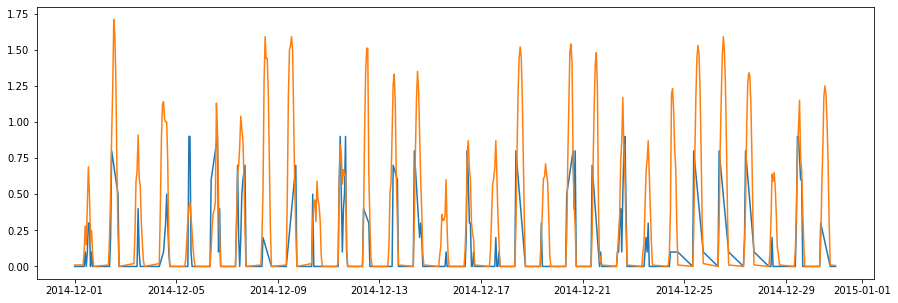

In [ ]:
# 서산 일조, 일사량
plt.subplots(figsize=(15, 5))
plt.plot(seosan_df['Forecast_time'][:12*30*2], seosan_df['일조'][:12*30*2])
plt.plot(seosan_df['Forecast_time'][:12*30*2], seosan_df['일사'][:12*30*2])

### Importing Forecast data (train_x)

In [ ]:
forecast_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/dacon/data/fin_preprocessing/new_dangjin_fcst.csv", parse_dates=["Forecast_time"])
df = pd.merge(forecast_df, seosan_df, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False)
df.head()

,Forecast_time,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud,Precipitation,Snow,방위각,고도,적경,적위,일조,일사
0,2016-12-02 00:00:00,0.4,0.0,0.0,67.0,8.6,356.0,1.0,NaN,NaN,340 03 04.02,-74 04 10.40,16 32 56.04,-21 55 49.38,0.0,0.014286
1,2016-12-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,030 19 39.37,-72 55 00.56,16 33 06.98,-21 56 11.79,0.0,0.015000
2,2016-12-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,060 54 26.99,-64 12 35.47,16 33 17.92,-21 56 34.29,0.0,0.015714
3,2016-12-02 03:00:00,-0.7,0.0,0.0,76.0,2.7,341.0,1.0,NaN,NaN,077 02 49.13,-53 01 39.40,16 33 28.84,-21 56 56.88,0.0,0.016429
4,2016-12-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,087 49 23.81,-41 10 38.68,16 33 39.74,-21 57 19.52,0.0,0.017143


### Forecaset data preprocessing

In [ ]:
def make_dataset(df):
  df['Temperature'] = df['Temperature'].interpolate()
  df['PrecipitationForm'] = df['PrecipitationForm'].interpolate()
  df['PrecipitationProb'] = df['PrecipitationProb'].interpolate()
  df['Humidity'] = df['Humidity'].interpolate()
  df['WindSpeed'] = df['WindSpeed'].interpolate()
  df['Cloud'] = df['Cloud'].interpolate()

  def angle_to_dir(x):
      if pd.isnull(x):
          return np.nan
      elif x >= 22.5 and x <67.5:
          return 'NE'
      elif x >= 67.5 and x < 112.5:
          return 'E'
      elif x >= 112.5 and x < 157.5:
          return 'SE'
      elif x >= 157.5 and x < 202.5:
          return 'S'
      elif x >= 202.5 and x < 247.5:
          return 'WS'
      elif x >= 247.5 and x < 292.5:
          return 'W'
      elif x >= 292.5 and x < 337.5:
          return 'NW'
      elif x >= 337.5 or x < 22.5:
          return 'N'

  def angle_to_cos(x):
      return np.cos(np.pi/180*(x-90))
  def angle_to_sin(x):
      return np.sin(np.pi/180*(x+90))

  df['WindDirection_x'] = df['WindDirection'].apply(angle_to_cos)
  df['WindDirection_y'] = df['WindDirection'].apply(angle_to_sin)
  df['Wind_x'] = df['WindDirection_x'] * df['WindSpeed']
  df['Wind_y'] = df['WindDirection_y'] * df['WindSpeed']

  df['WindDirection'] = df['WindDirection'].interpolate()

  df['WindDirection_catg'] = df['WindDirection'].apply(angle_to_dir)

  df['Wind_x'] = df['Wind_x'].interpolate()
  df['Wind_y'] = df['Wind_y'].interpolate()

  df['hour'] = pd.to_datetime(df['Forecast_time']).dt.hour
  df['day'] = pd.to_datetime(df['Forecast_time']).dt.day
  df['month'] = pd.to_datetime(df['Forecast_time']).dt.month

  wind = df[['Forecast_time', 'WindSpeed']]
  wind618 = wind[(wind['Forecast_time'].dt.hour >= 6) & (wind['Forecast_time'].dt.hour <= 18)]
  wind618['same_date'] = wind618.Forecast_time.dt.date

  new = wind618.groupby('same_date')['WindSpeed'].aggregate('mean').reset_index()
  new.rename(columns={"WindSpeed": "meanwind"}, inplace=True)
  wind618 = wind618.merge(new, on=['same_date'])
  wind618.drop('WindSpeed', axis=1, inplace=True)
  wind618.drop('same_date', axis=1, inplace=True)
  wind618.rename(columns={"meanwind": "WindSpeed"}, inplace=True)
  wind618.head(15)

  df['WindSpeed'] = wind618['WindSpeed']
  df = df.fillna(0)
  df = df[df.columns.difference(['방위각', '고도','적경', '적위', 'Snow', 'Precipitation', 'WindDirection_catg'])]
  return df

In [ ]:
df = make_dataset(df)
df.head()

,Cloud,Forecast_time,Humidity,PrecipitationForm,PrecipitationProb,Temperature,WindDirection,WindDirection_x,WindDirection_y,WindSpeed,Wind_x,Wind_y,day,hour,month,일사,일조
0,1.0,2016-12-02 00:00:00,67.0,0.0,0.0,0.400000,356.000000,-0.069756,0.997564,2.823077,-0.599906,8.579051,2,0,12,0.014286,0.0
1,1.0,2016-12-02 01:00:00,70.0,0.0,0.0,0.033333,351.000000,0.000000,0.000000,2.823077,-0.692948,6.570334,2,1,12,0.015000,0.0
2,1.0,2016-12-02 02:00:00,73.0,0.0,0.0,-0.333333,346.000000,0.000000,0.000000,2.823077,-0.785991,4.561617,2,2,12,0.015714,0.0
3,1.0,2016-12-02 03:00:00,76.0,0.0,0.0,-0.700000,341.000000,-0.325568,0.945519,2.823077,-0.879034,2.552900,2,3,12,0.016429,0.0
4,1.0,2016-12-02 04:00:00,80.0,0.0,0.0,-0.933333,341.333333,0.000000,0.000000,2.823077,-0.761132,2.240865,2,4,12,0.017143,0.0


## Model Fitting

In [ ]:
# train / test split
X = df.drop(['일조','일사', 'Forecast_time'], axis=1)
y = df[['일사','일조']]

In [ ]:
# Scaling
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# Train Data
X_train = X_ss[ int (X.shape [0] * 0.1):] 
X_test = X_ss[: int (X.shape [0] * 0.1)] 

# Test Data 
y_train = y_mm[int (X.shape [0] * 0.1):] 
y_test = y_mm[: int (X.shape [0] * 0.1)]  

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (34820, 14) (34820, 2)
Testing Shape (3868, 14) (3868, 2)


In [ ]:
# to form of tensor
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([34820, 1, 14]) torch.Size([34820, 2])
Testing Shape torch.Size([3868, 1, 14]) torch.Size([3868, 2])


In [ ]:
# Neural Network model
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(14, 16)
    self.fc2 = nn.Linear(16, 16)
    self.fc3 = nn.Linear(16, 2)
  
  def forward(self, x):
    x = x.view(-1, 14)

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = F.relu(x)
    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform(m.weight.data)

model= Net().to(device)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

criterion = nn.MSELoss()

for epoch in range(10000):
  outputs = model.forward(X_train_tensors_final.to(device))
  optimizer.zero_grad()
 
  loss = criterion(outputs, y_train_tensors.to(device))
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.17954
Epoch: 100, loss: 0.06389
Epoch: 200, loss: 0.04969
Epoch: 300, loss: 0.03985
Epoch: 400, loss: 0.03559
Epoch: 500, loss: 0.03352
Epoch: 600, loss: 0.03225
Epoch: 700, loss: 0.03132
Epoch: 800, loss: 0.03060
Epoch: 900, loss: 0.03006
Epoch: 1000, loss: 0.02962
Epoch: 1100, loss: 0.02927
Epoch: 1200, loss: 0.02897
Epoch: 1300, loss: 0.02862
Epoch: 1400, loss: 0.02825
Epoch: 1500, loss: 0.02801
Epoch: 1600, loss: 0.02780
Epoch: 1700, loss: 0.02761
Epoch: 1800, loss: 0.02742
Epoch: 1900, loss: 0.02717
Epoch: 2000, loss: 0.02693
Epoch: 2100, loss: 0.02670
Epoch: 2200, loss: 0.02649
Epoch: 2300, loss: 0.02630
Epoch: 2400, loss: 0.02613
Epoch: 2500, loss: 0.02597
Epoch: 2600, loss: 0.02584
Epoch: 2700, loss: 0.02573
Epoch: 2800, loss: 0.02563
Epoch: 2900, loss: 0.02553
Epoch: 3000, loss: 0.02543
Epoch: 3100, loss: 0.02535
Epoch: 3200, loss: 0.02529
Epoch: 3300, loss: 0.02524
Epoch: 3400, loss: 0.02520
Epoch: 3500, loss: 0.02516
Epoch: 3600, loss: 0.02511
Epoch: 3700, 

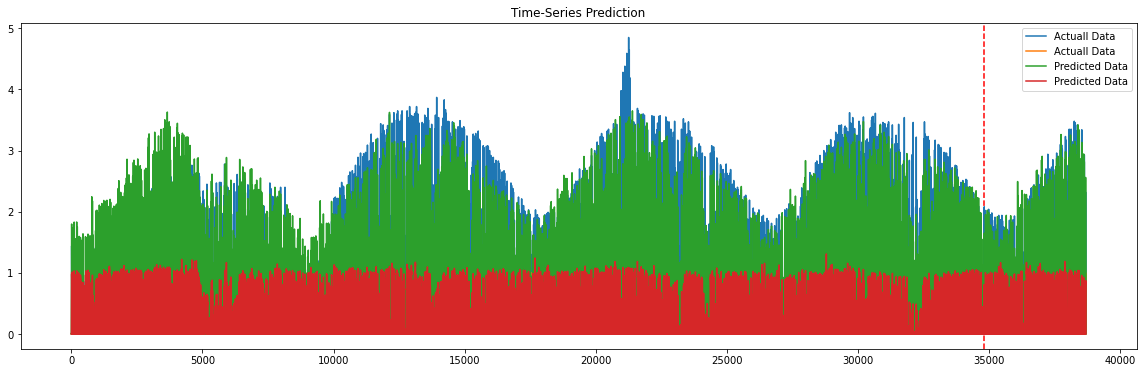

In [ ]:
# Visualization
df_X_ss = ss.transform(X)
df_y_mm = mm.transform(y)

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset\
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = model(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(20,6)) #plotting
plt.axvline(x=int (X.shape [0] * 0.9) , c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/Colab Notebooks/dacon/일조일사/mlp_당진.pt')

# eval

In [ ]:
my = torch.load('/content/gdrive/MyDrive/Colab Notebooks/dacon/일조일사/mlp_당진.pt')
my.eval()

Net(
  (fc1): Linear(in_features=14, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
test_loss1 = 0
test_loss2 = 0
correct1 = 0
correct2 = 0

with torch.no_grad():
    data, target = X_test_tensors_final.to(device), y_test_tensors.to(device)
    output = my(data)

    test_loss1 += torch.nn.functional.mse_loss(output[:, 0], target[:,0], reduction='sum').item()
    test_loss2 += torch.nn.functional.mse_loss(output[:, 1], target[:,1], reduction='sum').item()

    pred1 = output[:, 0]#.argmax(keepdim = True)
    pred2 = output[:, 1]#.argmax(keepdim = True)

    correct1 += pred1.eq(target[:,0].view_as(output[:, 0])).sum().item()
    correct2 += pred2.eq(target[:,1].view_as(output[:, 1])).sum().item()

test_loss1 /= len(data)
test_loss2 /= len(data)

print('Test set: Average Loss: {:.4f}\n'.format(test_loss1))

print('Test set: Average Loss: {:.4f}'.format(test_loss2))


Test set: Average Loss: 0.0040

Test set: Average Loss: 0.0458


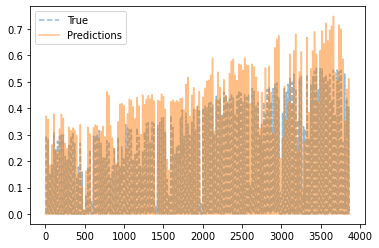

In [ ]:
# Insolation
plt.plot(target[:,0].cpu().numpy(),  '--',label='True', alpha=0.5)
plt.plot(output[:, 0].cpu().numpy(), label='Predictions', alpha=0.5)
plt.legend()

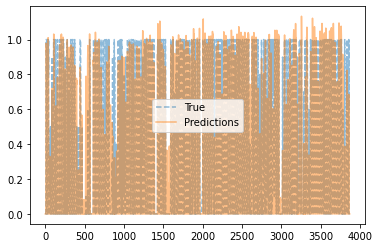

In [ ]:
# Amount of Sunshine
plt.plot(target[:,1].cpu().numpy(),  '--', label='True', alpha=0.5)
plt.plot(output[:, 1].cpu().numpy(), label='Predictions', alpha=0.5)
plt.legend()

# inference

In [ ]:
newone1 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dacon/일조일사/data/dangjin0702_at0701.csv')
newone1.Forecast_time = pd.to_datetime(newone1.Forecast_time)
newone2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dacon/일조일사/data/dangjin0703_at0702.csv')
newone2.Forecast_time = pd.to_datetime(newone2.Forecast_time)

dfdf = pd.concat([newone1, newone2])
newdf = make_dataset(dfdf)
newdf = newdf.drop(['Forecast_time'], axis=1)
newdf

,Cloud,Humidity,PrecipitationForm,PrecipitationProb,Temperature,WindDirection,WindDirection_x,WindDirection_y,WindSpeed,Wind_x,Wind_y,day,hour,month
0,1.000000,80.000000,0.000000,0.000000,22.000000,344.000000,-2.756374e-01,0.961262,2.700000,-4.961472e-01,1.730271,2,0,7
1,1.000000,81.666667,0.000000,0.000000,22.000000,274.333333,-9.971413e-01,0.075559,2.700000,-1.395998e+00,0.105782,2,1,7
2,1.000000,83.333333,0.000000,0.000000,22.000000,204.666667,-4.173385e-01,-0.908751,2.700000,-4.173385e-01,-0.908751,2,2,7
3,1.000000,85.000000,0.000000,0.000000,22.000000,135.000000,7.071068e-01,-0.707107,2.700000,4.242641e-01,-0.424264,2,3,7
4,1.000000,85.000000,0.000000,0.000000,21.666667,132.333333,7.392394e-01,-0.673443,2.700000,7.885221e-01,-0.718339,2,4,7
5,1.000000,85.000000,0.000000,0.000000,21.333333,129.666667,7.697710e-01,-0.638320,2.700000,1.180316e+00,-0.978757,2,5,7
6,1.000000,85.000000,0.000000,0.000000,21.000000,127.000000,7.986355e-01,-0.601815,2.700000,1.597271e+00,-1.203630,2,6,7
7,1.666667,80.000000,0.000000,6.666667,22.666667,204.666667,-4.173385e-01,-0.908751,2.700000,-1.015524e+00,-2.211294,2,7,7
8,2.333333,75.000000,0.000000,13.333333,24.333333,282.333333,-9.769215e-01,0.213599,2.700000,-2.800508e+00,0.612316,2,8,7
9,3.000000,70.000000,0.000000,20.000000,26.000000,360.000000,-1.836970e-16,1.000000,2.700000,-6.062002e-16,3.300000,2,9,7


In [ ]:
ss = StandardScaler()

X_ss = ss.fit_transform(newdf)
test = Variable(torch.Tensor(X_ss))
test_final = torch.reshape(test,  (test.shape[0], 1, test.shape[1]))
test_final

tensor([[[-1.2067,  0.6421, -0.4295, -0.9661, -1.0597,  2.5882, -1.2627,
           2.2816, -0.9199, -1.0698,  1.3962, -1.0000, -1.6613,  0.0000]],

        [[-1.2067,  0.7932, -0.4295, -0.9661, -1.0597,  1.6783, -2.4196,
           0.6199, -0.9199, -1.3679,  0.6955, -1.0000, -1.5169,  0.0000]],

        [[-1.2067,  0.9442, -0.4295, -0.9661, -1.0597,  0.7684, -1.4899,
          -1.2269, -0.9199, -1.0436,  0.2578, -1.0000, -1.3724,  0.0000]],

        [[-1.2067,  1.0953, -0.4295, -0.9661, -1.0597, -0.1415,  0.3130,
          -0.8486, -0.9199, -0.7648,  0.4668, -1.0000, -1.2279,  0.0000]],

        [[-1.2067,  1.0953, -0.4295, -0.9661, -1.1766, -0.1763,  0.3646,
          -0.7854, -0.9199, -0.6442,  0.3400, -1.0000, -1.0835,  0.0000]],

        [[-1.2067,  1.0953, -0.4295, -0.9661, -1.2935, -0.2111,  0.4135,
          -0.7195, -0.9199, -0.5144,  0.2276, -1.0000, -0.9390,  0.0000]],

        [[-1.2067,  1.0953, -0.4295, -0.9661, -1.4104, -0.2460,  0.4598,
          -0.6510, -0.9199, -0.37

In [ ]:
my = torch.load('/content/gdrive/MyDrive/Colab Notebooks/dacon/일조일사/mlp_당진.pt')
my.eval()

test_loss1 = 0
test_loss2 = 0
correct1 = 0
correct2 = 0

with torch.no_grad():
    data = test_final.to(device)
    output = my(data)

    pred1 = output[:, 0]
    pred2 = output[:, 1]

In [ ]:
pred1

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2032,
        0.4215, 0.4702, 0.5668, 0.6953, 0.7487, 0.6981, 0.6413, 0.4828, 0.4177,
        0.2008, 0.1905, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0237, 0.1239, 0.2636,
        0.3347, 0.3515, 0.3050, 0.1849, 0.0959, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0')

In [ ]:
pred2

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0303, 0.7579,
        1.1258, 0.8845, 0.9717, 1.0020, 1.0157, 1.0141, 1.0170, 0.8981, 0.8685,
        0.5682, 0.8531, 0.5620, 0.4153, 0.0032, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1094, 0.1703, 0.2855,
        0.2724, 0.4024, 0.3809, 0.2541, 0.2027, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0')

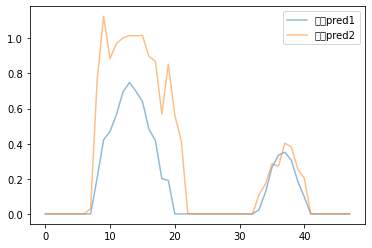

In [ ]:
plt.plot(pred1.cpu().numpy(), label='일사pred1', alpha=0.5)
plt.plot(pred2.cpu().numpy(), label='일조pred2', alpha=0.5)
plt.legend()

In [ ]:
result = pd.DataFrame(dfdf.Forecast_time)
result['일사'] = pd.DataFrame(pred1).astype("float")
result['일조'] = pd.DataFrame(pred2).astype("float")
result

,Forecast_time,일사,일조
0,2021-07-02 00:00:00,0.000000,0.000000
1,2021-07-02 01:00:00,0.000000,0.000000
2,2021-07-02 02:00:00,0.000000,0.000000
3,2021-07-02 03:00:00,0.000000,0.000000
4,2021-07-02 04:00:00,0.000000,0.000000
5,2021-07-02 05:00:00,0.000000,0.000000
6,2021-07-02 06:00:00,0.000000,0.000000
7,2021-07-02 07:00:00,0.000000,0.030328
8,2021-07-02 08:00:00,0.203232,0.757894
9,2021-07-02 09:00:00,0.421469,1.125798


In [ ]:
result.to_csv("/content/gdrive/MyDrive/Colab Notebooks/dacon/일조일사/data/dangin0702_0703_sunlight.csv", index = False)
# apply to Dangin as well